We use "PDEFIND" method here to "discover" swift hohenberg from
its numerical simulations. Swift-Hohenberg reads
$$ u_t = -(\Delta+1)^2 u + Ru - u^3 $$
$$ \\ u_t = -\Delta^2 u -2\Delta u -u + Ru - u^3 $$
We first make an overly simplified experiment, where our library
of functions consist of 1, u, u^3, lap(u) and biharm(u)

In [1]:
import matplotlib.pyplot as plt
from myPDEFIND import *
import scipy.io as sio
import numpy as np

Load data

In [2]:
data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/sh2.mat")

Display sample of results (snapshot in time)

Text(0, 0.5, 'y')

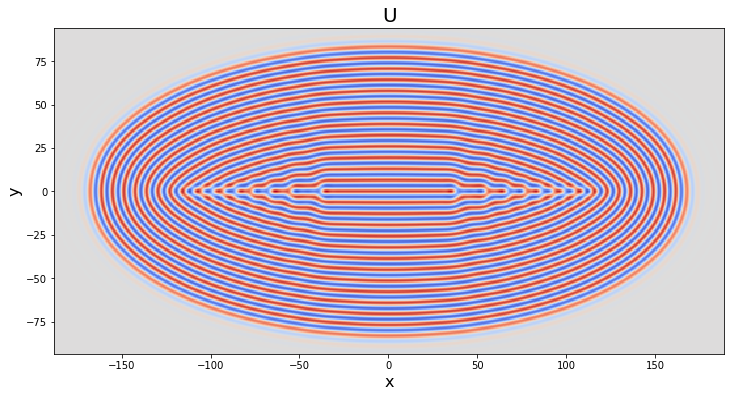

In [3]:
t_full = data['tt'].T[:,0]
x = data['xx'].T[0,:]
y = data['yy'].T[0,:]
U_full = data['uu']
#take last 400 time steps
t = t_full[599:999]
U = U_full[:,:,599:999]

nx = len(x)
ny = len(y)
steps = len(t)
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
xx, yy = np.meshgrid(x,y)
ax1.pcolor(xx,yy,U[:,:,10].T,cmap='coolwarm')
ax1.set_title('U', fontsize = 20)
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('y', fontsize = 16)

Dataset is large- so we randomly 150,000 data points
Generate a dictionary with integer keys, whose values are tuples
representing indices we will use to sample U[:,:,:]

In [4]:

# Sample a collection of data points.  See figure 1 panel 2a.
np.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    if p % 1000 == 0:
        print(p)
    x = np.random.choice(np.arange(boundary,nx-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,ny-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,12*t+10]
        count = count + 1

0
1000
2000
3000
4000


Consruct $\Theta(U)$ and $U_t$

In [5]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
biharmu = np.zeros((num_points,1))
lapu = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 8 # degree of polynomial to use

# setting parameters for biharmonic and laplacian calculation
# ToDo: Make these derivable from data
Lx = 120*np.pi   # Size of enclosing periodic rectangle
Ly = 60*np.pi

for p in points.keys():
    if p % 1000==0:
        print(p)

    [x,y,t] = points[p]

    # value of function
    u[p] = U[x,y,t]

    # time derivative
    ut[p] = PolyDiffPoint(U[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]

    #biharmonic and laplacian terms
    biharmu[p] = Biharmonic(U[:,:,t],Lx,Ly)[x,y]
    lapu[p] = Laplacian(U[:,:,t],Lx,Ly)[x,y]


    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000


In [6]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = u
X_ders = np.hstack([np.ones((num_points,1)),biharmu,lapu])
X_ders_descr = ['','biharm_u', 'lap_u']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
['1'] + description[1:]

['1',
 'biharm_u',
 'lap_u',
 'u',
 'u^2',
 'u^3',
 'ubiharm_u',
 'u^2biharm_u',
 'u^3biharm_u',
 'ulap_u',
 'u^2lap_u',
 'u^3lap_u']

In [8]:
c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

u_t = (0.000056 +0.000000i)ubiharm_u
    + (-0.000083 +0.000000i)u^3biharm_u
    + (0.000116 +0.000000i)ulap_u
    + (-0.000181 +0.000000i)u^3lap_u
   


## References
Rudy, Samuel H, Steven L Brunton, Joshua L Proctor, and J Nathan Kutz. "Data-driven Discovery of Partial Differential Equations." Science Advances 3.4 (2017): E1602614. Web.

Schaeffer, Hayden. "Learning Partial Differential Equations via Data Discovery and Sparse Optimization." Proceedings of the Royal Society. A, Mathematical, Physical, and Engineering Sciences 473.2197 (2017): 20160446. Web.